# Basic Quantum K-Means
---
## Objective
The **objective** of this is to attempt to implement a basic Quantum K-Means algorithm

## Step 1: Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler
from scipy.linalg import norm

from qiskit import QuantumCircuit
from qiskit.circuit.library import StatePreparation
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit import transpile
 #from qiskit.algorithms import AmplitudeEstimation

## Step 2: Quantum Circuit Functions

In [2]:
"""
Create a quantum circuit to perform the swap between the two states
Returns the circuit
"""
def create_swap_test_circuit(state1, state2):
    n_qubits = int(np.ceil(np.log2(len(state1))))

    total_qubits = 1 + 2 * n_qubits
    qc = QuantumCircuit(total_qubits, 1)

    state_prep1 = StatePreparation(state1)
    qc.append(state_prep1, range(1, 1+n_qubits))

    state_prep2 = StatePreparation(state2)
    qc.append(state_prep2, range(1+n_qubits, 1+2*n_qubits))

    qc.h(0)

    for i in range(n_qubits):
        qc.cswap(0, 1+i, 1+n_qubits+i)

    qc.h(0)
    qc.measure(0,0)

    return qc

"""
Computes the distance between vectors
"""
def compute_quantum_distance(x, y, shots=100):
    x_norm = x / norm(x)
    y_norm = y / norm(y)

    n_qubits = int(np.ceil(np.log2(len(x))))
    target_length = 2**n_qubits

    if len(x_norm) < target_length:
        x_norm = np.pad(x_norm, (0, target_length - len(x_normm)))
    if len(y_norm) < target_length:
        y_norm = np.pad(y_norm, (0, target_length - len(y_norm)))

    qc = create_swap_test_circuit(x_norm, y_norm)

    backend = AerSimulator()
    transpiled_qc = transpile(qc, backend)

    job = backend.run(transpiled_qc, shots=shots)
    result = job.result()
    counts = result.get_counts()

    p0 = counts.get('0', 0) / shots

    inner_product_squared = 2 * p0 - 1
    inner_product = np.sqrt(max(0, inner_product_squared))
    distance = np.sqrt(2 - 2 * inner_product)

    return distance
    

## Step 3: Data Generation and Preperation

In [3]:
def generate_data(n_samples=100, centers=3, random_state=42):
    X, y = make_blobs(n_samples=n_samples, centers=centers, random_state=random_state, cluster_std=0.8)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    return X, y

def initialize_centroids(X, k):
    random_indices = np.random.choice(len(X), k, replace=False)
    return X[random_indices]

## Step 4: Clustering Functions

In [4]:
def assign_clusters(X, centroids):
    clusters = [[] for _ in range(len(centroids))]
    cluster_ids = np.zeros(len(X))

    for i, point in enumerate(X):
        distances = [compute_quantum_distance(point, centroid) for centroid in centroids]
        cluster_idx = np.argmin(distances)
        clusters[cluster_idx].append(point)
        cluster_ids[i] = cluster_idx

    return clusters, cluster_ids

def update_centroids(clusters):
    new_centroids = []
    for cluster in clusters:
        if len(cluster) > 0:
            new_centroid = np.mean(cluster, axis=0)
            new_centroids.append(new_centroid)
    return np.array(new_centroids)

def has_converged(centroids, new_centroids, tol=1e-4):
    if len(centroids) != len(new_centroids): 
        return False
    return np.all(norm(centroids - new_centroids, axis=1) < tol)

## Step 5: Main Quantum K-Means Algorithm

In [5]:
def quantum_kmeans(X, k, max_iter=10):
    centroids = initialize_centroids(X, k)
    convergence_history = []

    for iteration in range(max_iter):
        clusters, labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(clusters)

        if len(centroids) == len(new_centroids): 
            convergence = np.mean(norm(centroids - new_centroids, axis=1))
            convergence_history.append(convergence)

        if has_converged(centroids, new_centroids):
            print(f"Converged after {iteration+1} iterations")
            break

    return labels, centroids, convergence_history

## Step 6: Evaluation and Visualization

In [6]:
from sklearn.metrics import adjusted_rand_score, silhouette_score

def evaluate_clustering(X, true_labels, predicated_labels):
    ari = adjusted_rand_score(true_labels, predicated_labels)
    silhouette = silhouette_score(X, predicated_labels)

    print("Adjusted Rand Index: ", ari)
    print("Silhouette Score: ", silhouette)

    return ari, silhouette

def plot_results(X, true_labels, quantum_labels, centroids, convergence_history): 
    plt.figure(figsize=(15, 5))
    
    # True clusters
    plt.subplot(1, 3, 1)
    plt.scatter(X[:, 0], X[:, 1], c=true_labels, cmap='viridis', alpha=0.7)
    plt.title("True Clusters")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    
    # Quantum K-Means clusters
    plt.subplot(1, 3, 2)
    plt.scatter(X[:, 0], X[:, 1], c=quantum_labels, cmap='viridis', alpha=0.7)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
    plt.title("Quantum K-Means Clustering")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend() 
    plt.subplot(1, 3, 3)
    plt.plot(convergence_history, marker='o')
    plt.title("Convergence History")
    plt.xlabel("Iteration")
    plt.ylabel("Centroid Change")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

## Step 7: Main Execution

Adjusted Rand Index:  0.4402616047216462
Silhouette Score:  0.35394706484992927


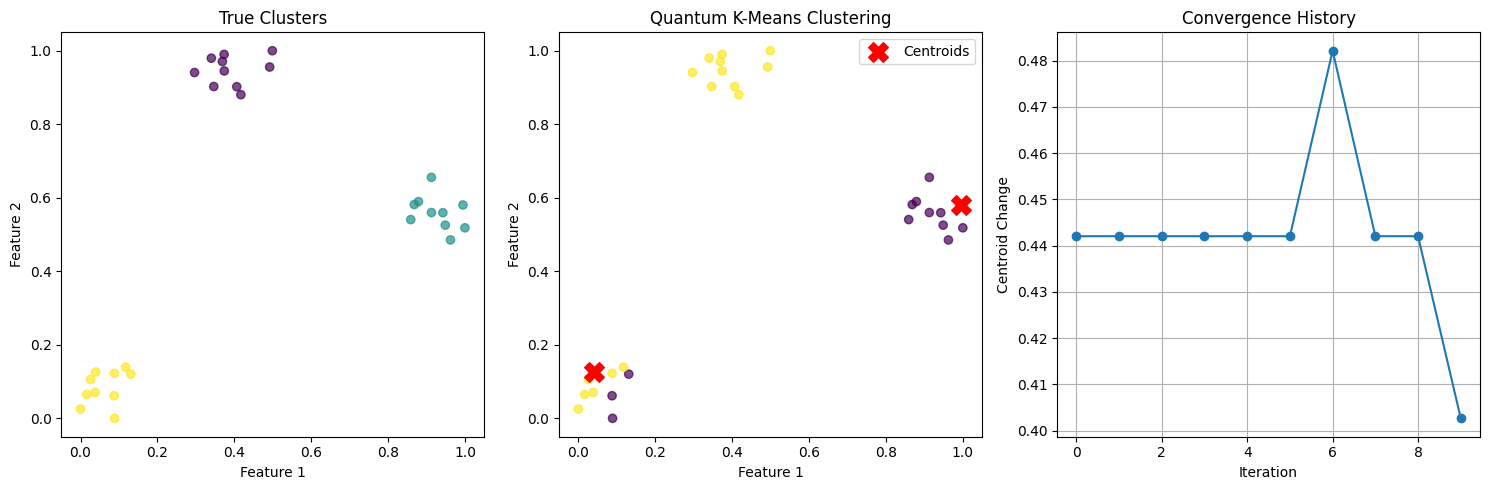

In [7]:
if __name__ == "__main__": 
    X, true_labels = generate_data(n_samples=30, centers=3)
    k=2
    quantum_labels, centroids, convergence_history = quantum_kmeans(X, k)

    ari, silhouette = evaluate_clustering(X, true_labels, quantum_labels)

    plot_results(X, true_labels, quantum_labels, centroids, convergence_history)

## Notes
This is still in progress. Additionally the next step would be to implement k-means++, where one would choose the centroids at the start in a more effective way.